# Analyzing Generated Questions

## Imports and Depdendencies

### Imports

In [19]:
from datasets import Dataset, load_dataset
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

## Question Diversity

In [7]:
single_hop_question_dataset = load_dataset("sumuks/yourbench_y1_single_hop_questions", split="train").to_pandas()
single_hop_question_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27769 entries, 0 to 27768
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   question_id               27769 non-null  object
 1   document_id               27769 non-null  object
 2   document_name             27769 non-null  object
 3   document_category         27769 non-null  object
 4   document_summary          27769 non-null  object
 5   chunk_location_id         27769 non-null  int64 
 6   chunk                     27769 non-null  object
 7   test_audience             27769 non-null  object
 8   full_generation_response  27769 non-null  object
 9   document_analysis         27769 non-null  object
 10  question_type             27769 non-null  object
 11  thought_process           27769 non-null  object
 12  question                  27769 non-null  object
 13  answer                    27769 non-null  object
 14  estimated_difficulty  

In [16]:
question_types = single_hop_question_dataset["question_type"].unique()
question_types

array(['analytical', 'application-based', 'conceptual', 'counterfactual',
       'factual', 'open-ended', 'edge-case', 'clarification',
       'true-false', 'false-premise'], dtype=object)

In [9]:
# lets get the various different generating models
generating_models = single_hop_question_dataset["generating_model"].unique()
generating_models


array(['meta-llama/Llama-3.3-70B-Instruct', 'gpt-4o-mini',
       'Qwen/Qwen2.5-72B-Instruct',
       'mistralai/Mistral-Small-Instruct-2409',
       'mNyxKrage/Microsoft_Phi-4', 'amazon/nova-lite-v1',
       'anthropic/claude-3.5-haiku',
       'mistralai/Mistral-Large-Instruct-2411', 'gpt-4o'], dtype=object)

In [13]:
model_renaming_dict = {
    "meta-llama/Llama-3.3-70B-Instruct" : "Llama 70B",
    "gpt-4o-mini" : "GPT-4o Mini",
    "gpt-4o" : "GPT-4o",
    "mistralai/Mistral-Small-Instruct-2409" : "Mistral Small",
    "mistralai/Mistral-Large-Instruct-2411" : "Mistral Large",
    "mNyxKrage/Microsoft_Phi-4" : "Phi 4",
    "Qwen/Qwen2.5-72B-Instruct" : "Qwen2.5 72B",
    "anthropic/claude-3.5-haiku" : "Claude 3.5 Haiku",
    "amazon/nova-lite-v1" : "Amazon Nova Lite",
}

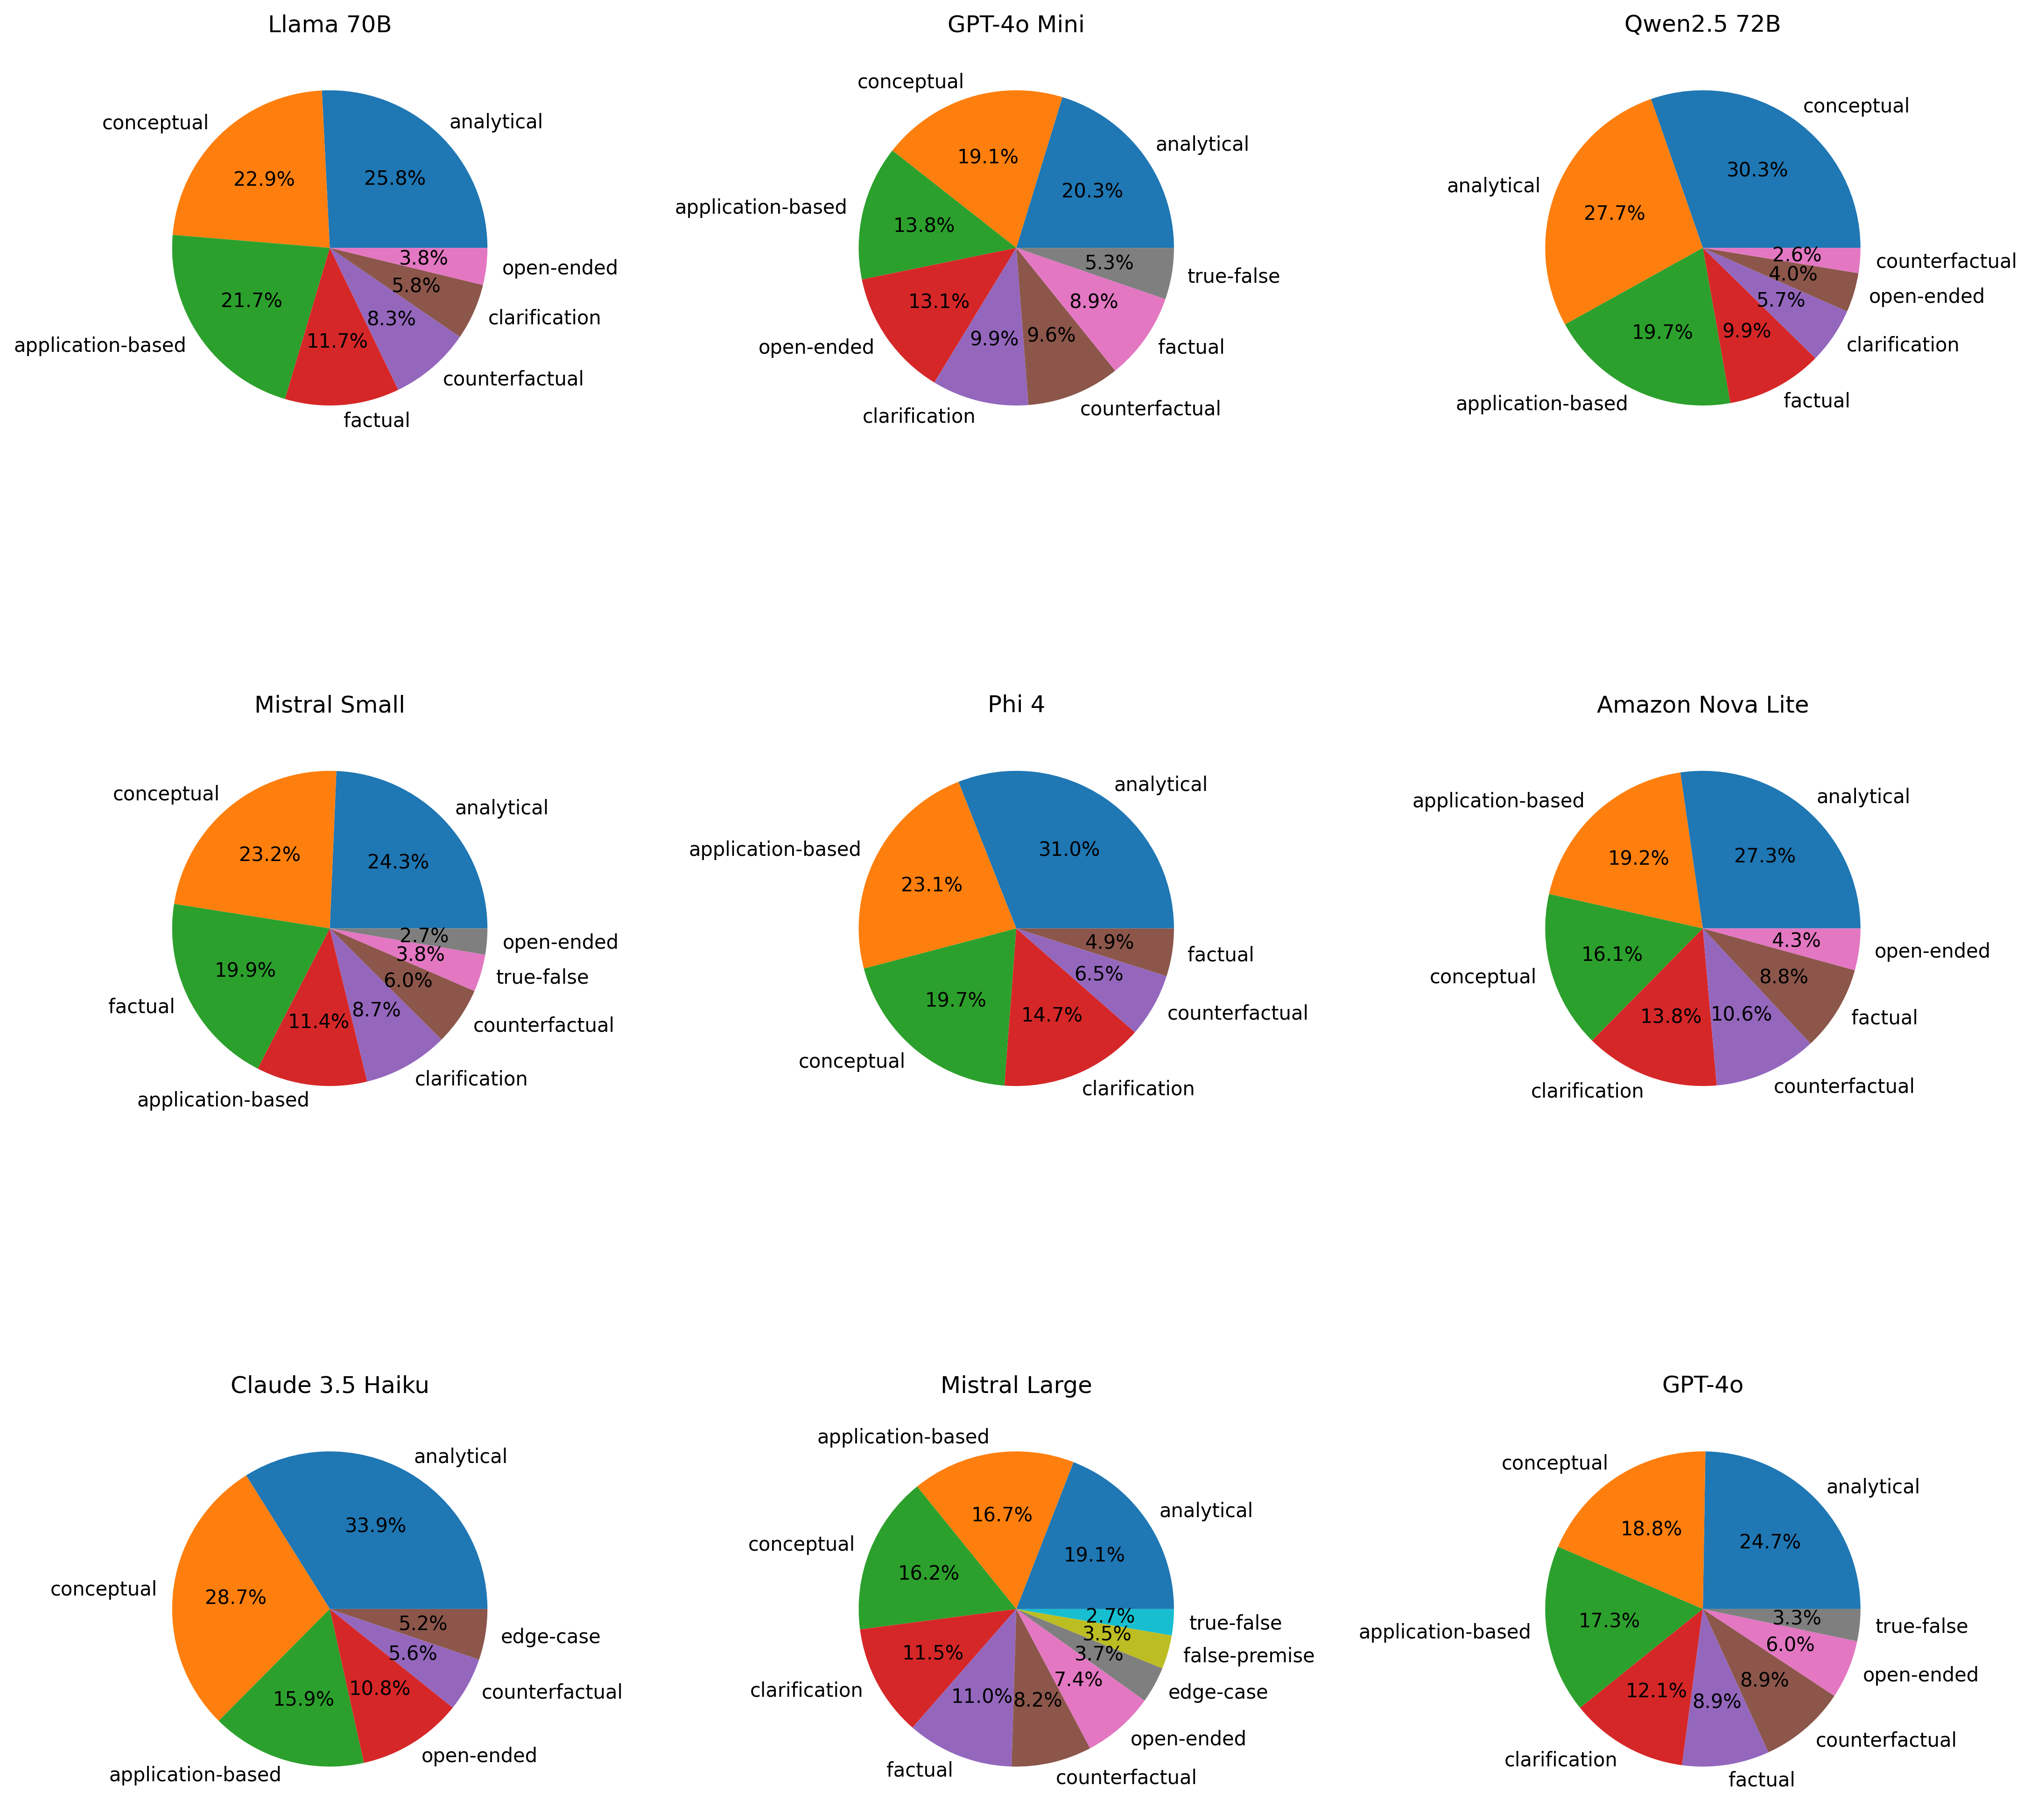

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), dpi=300)
axes = axes.ravel()

# For each model
for idx, model in enumerate(generating_models):
    # Filter data for current model
    model_data = single_hop_question_dataset[single_hop_question_dataset['generating_model'] == model]
    
    # Count question types and calculate percentages
    question_types = model_data['question_type'].value_counts()
    percentages = question_types / len(model_data) * 100
    
    # Filter out categories less than 2%
    mask = percentages >= 2
    filtered_types = question_types[mask]
    
    # Create pie chart
    axes[idx].pie(filtered_types.values, 
                  labels=filtered_types.index, 
                  autopct='%1.1f%%')
    axes[idx].set_title(model_renaming_dict[model], pad=10)

plt.tight_layout(pad=3.0)
plt.show()

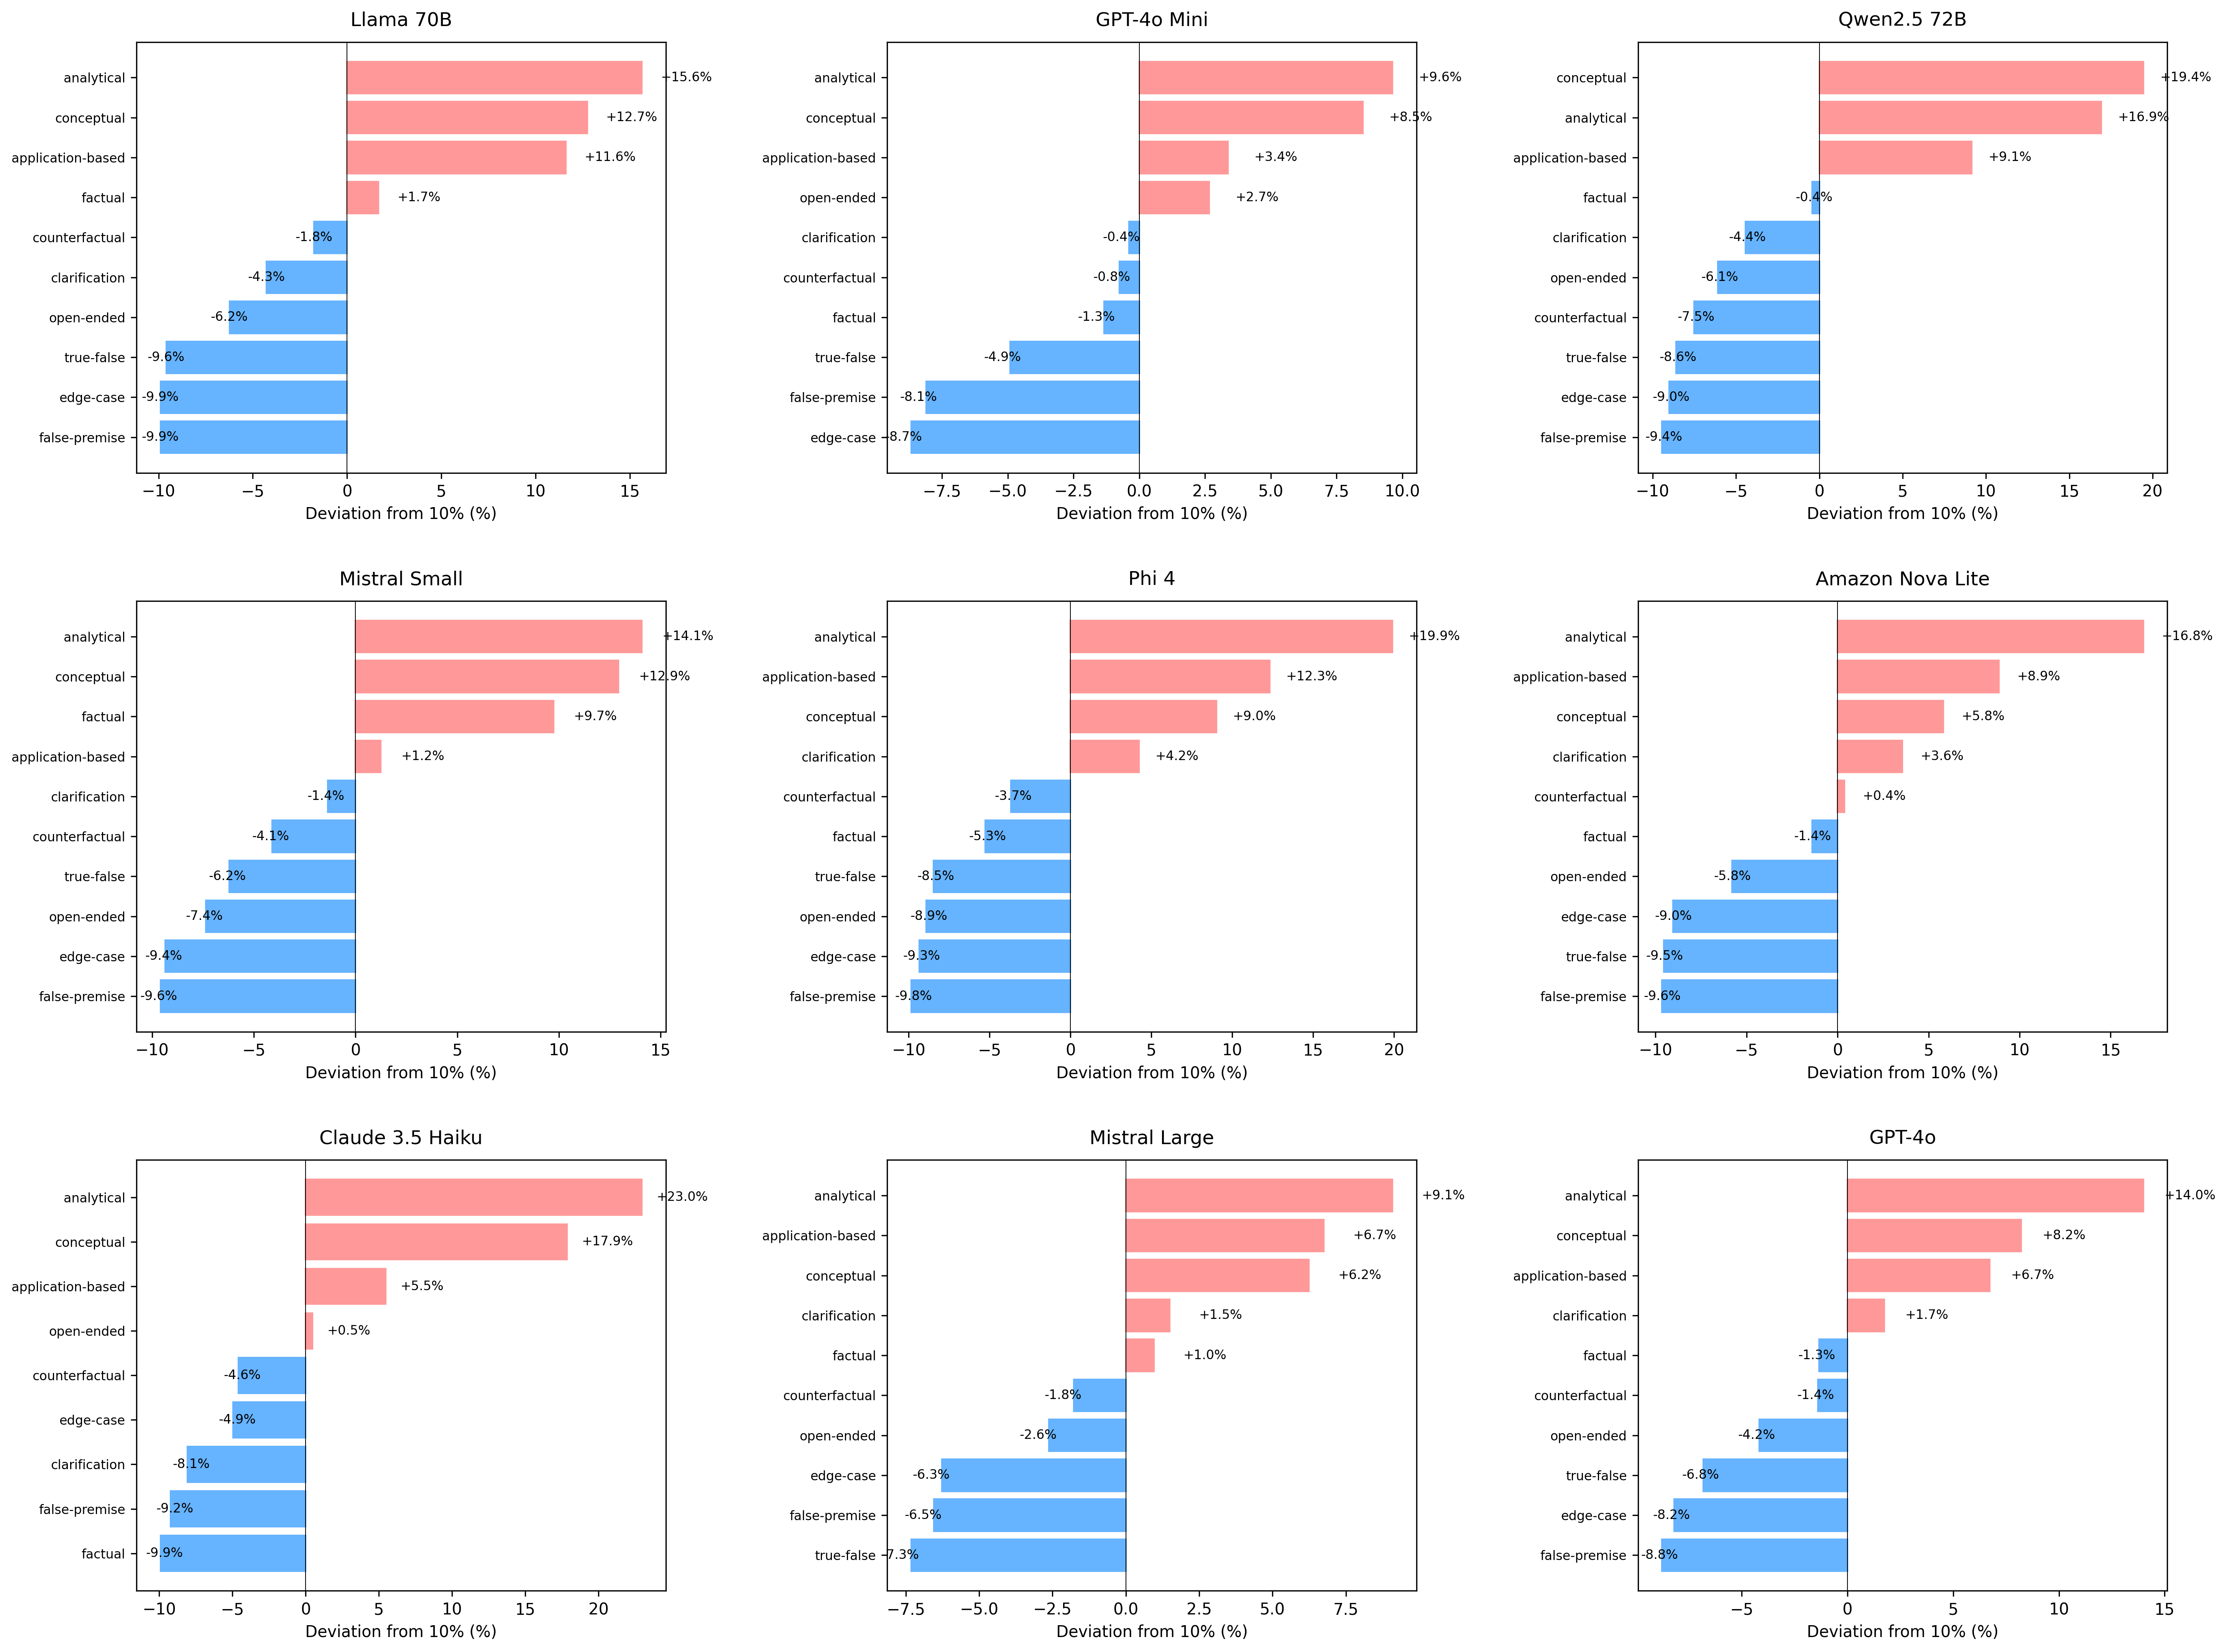

In [17]:
# Set up the plot
fig, axes = plt.subplots(3, 3, figsize=(20, 15), dpi=300)
axes = axes.ravel()

# Expected percentage for each type (10%)
expected_pct = 10

# Define colors for positive and negative deviations
colors = ['#ff9999', '#66b3ff']  # red for positive, blue for negative

for idx, model in enumerate(generating_models):
    # Filter data for current model
    model_data = single_hop_question_dataset[single_hop_question_dataset['generating_model'] == model]
    
    # Calculate actual percentages
    actual_counts = model_data['question_type'].value_counts()
    actual_pct = (actual_counts / len(model_data) * 100)
    
    # Calculate deviations from 10%
    deviations = actual_pct - expected_pct
    
    # Sort deviations for better visualization
    deviations_sorted = deviations.sort_values()
    
    # Create horizontal bar chart
    bars = axes[idx].barh(range(len(deviations_sorted)), deviations_sorted)
    
    # Color the bars based on positive/negative values
    for bar in bars:
        if bar.get_width() < 0:
            bar.set_color(colors[1])  # blue for negative
        else:
            bar.set_color(colors[0])  # red for positive
    
    # Add a vertical line at x=0
    axes[idx].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # Customize the plot
    axes[idx].set_title(model_renaming_dict[model], pad=10)
    axes[idx].set_yticks(range(len(deviations_sorted)))
    axes[idx].set_yticklabels(deviations_sorted.index, fontsize=8)
    axes[idx].set_xlabel('Deviation from 10% (%)')
    
    # Add value labels on the bars
    for i, v in enumerate(deviations_sorted):
        axes[idx].text(v + (1 if v >= 0 else -1), 
                      i,
                      f'{v:+.1f}%',
                      va='center',
                      fontsize=8)

plt.tight_layout(pad=3.0)
plt.show()

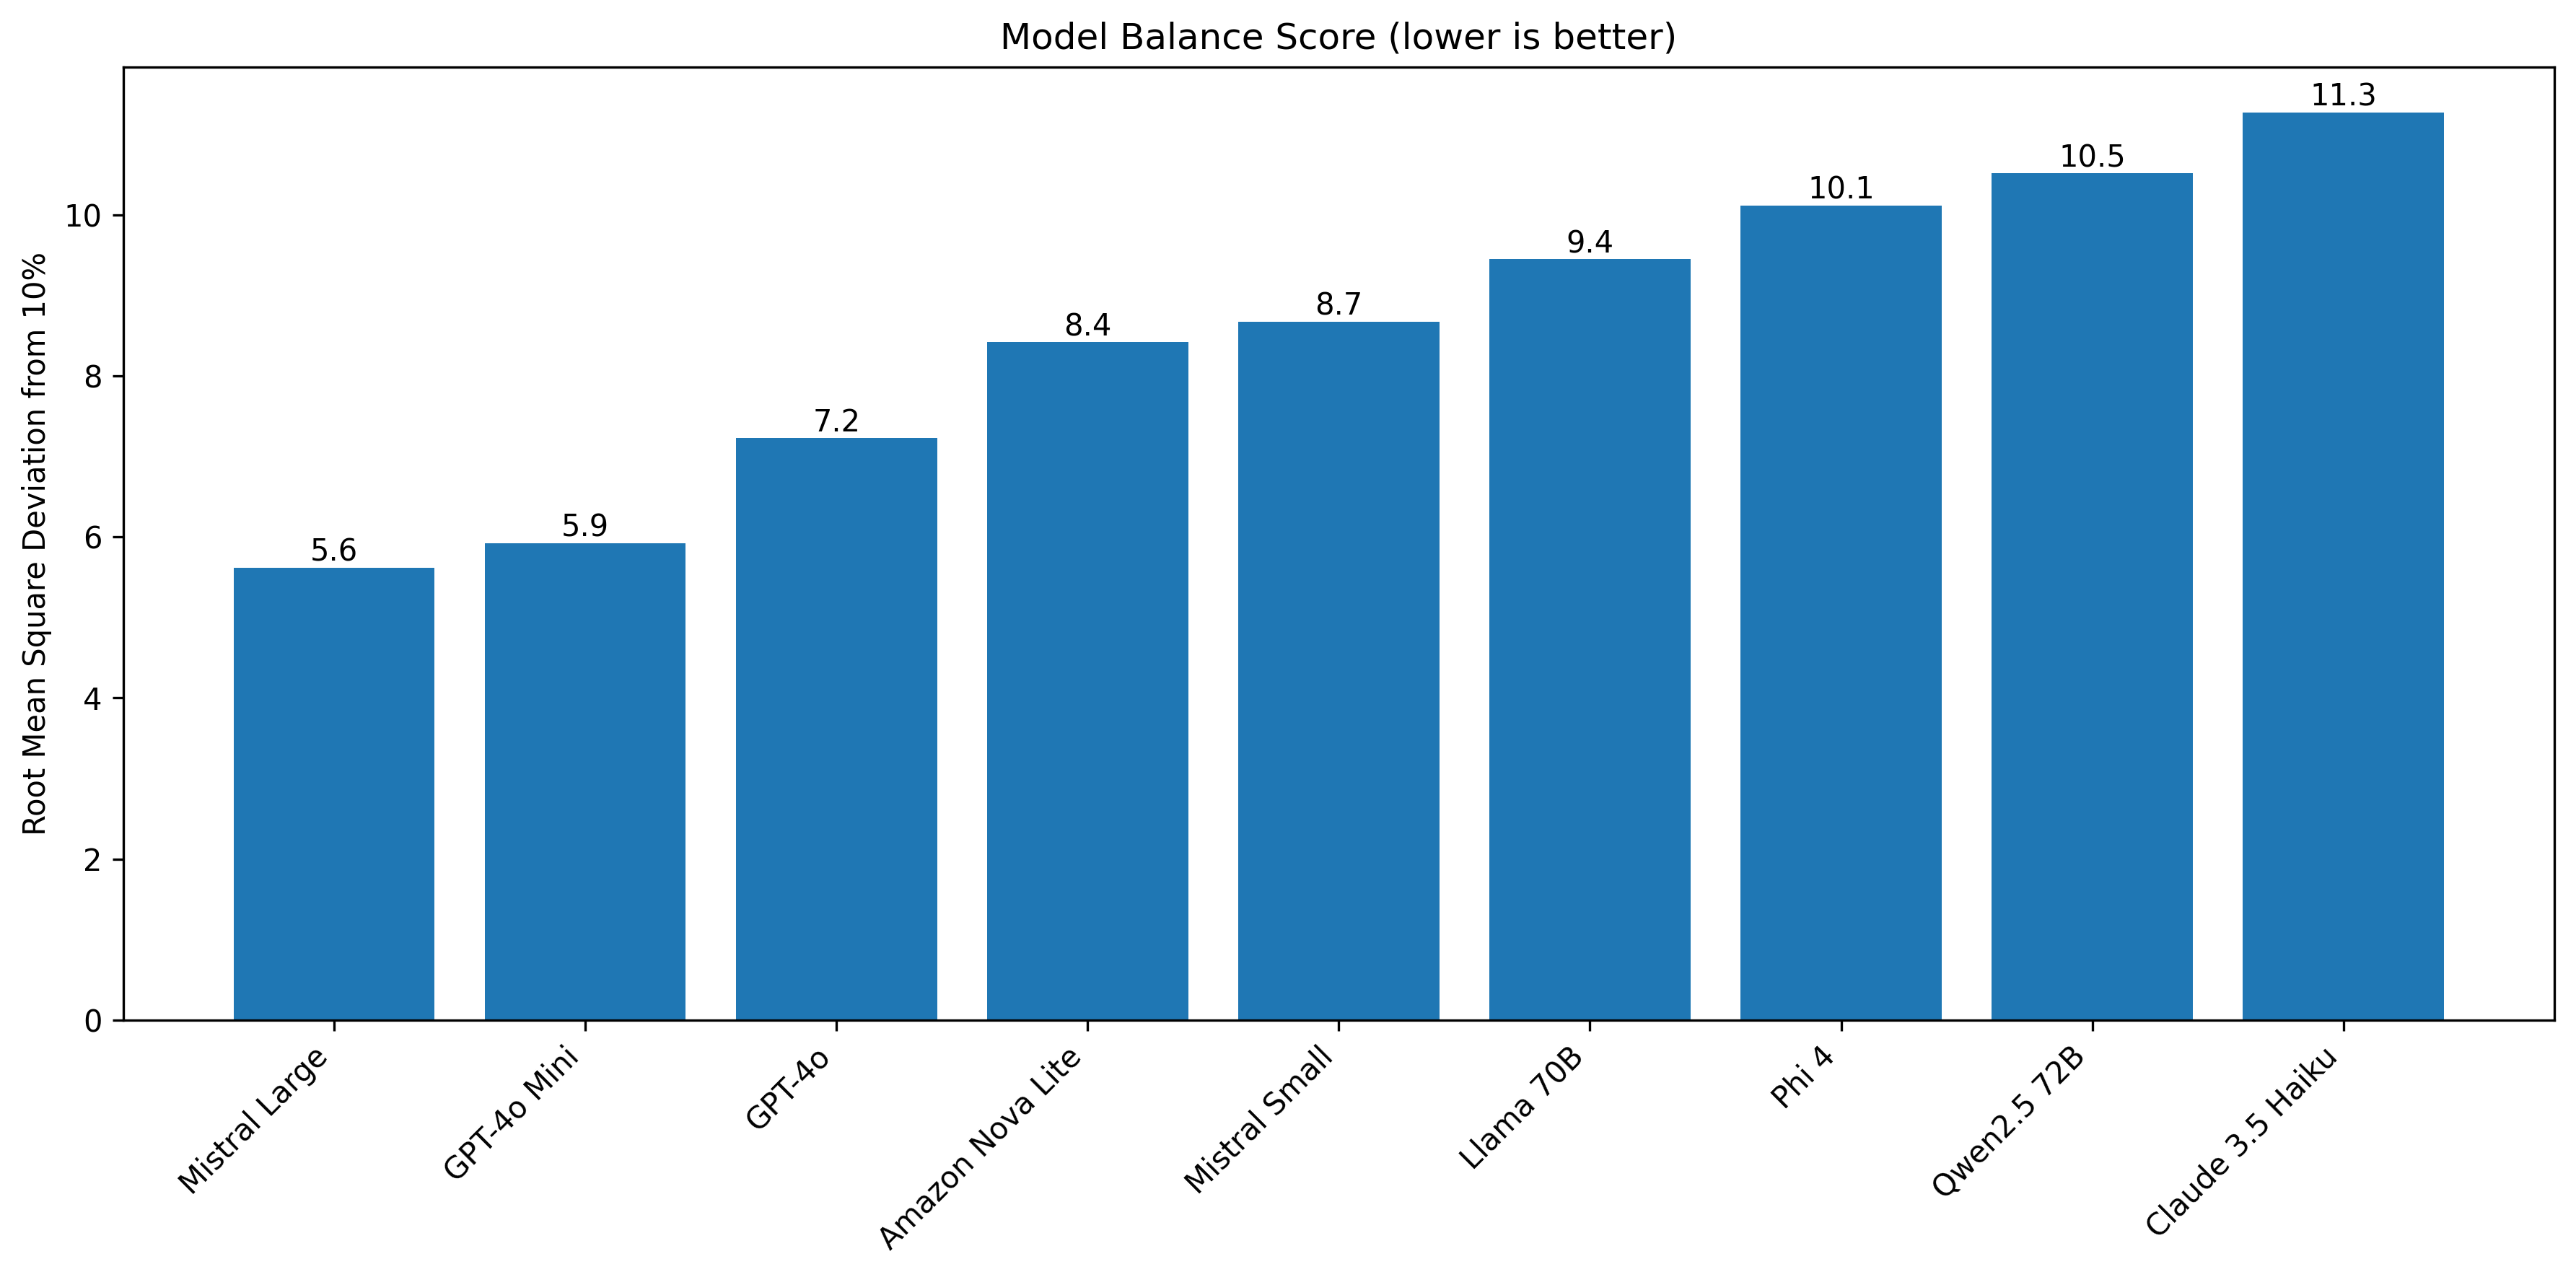

In [20]:
# Calculate RMSD (Root Mean Square Deviation) for each model
balance_scores = {}
for model in generating_models:
    model_data = single_hop_question_dataset[single_hop_question_dataset['generating_model'] == model]
    actual_counts = model_data['question_type'].value_counts()
    actual_pct = (actual_counts / len(model_data) * 100)
    
    # Fill in missing categories with 0%
    for qt in question_types:
        if qt not in actual_pct.index:
            actual_pct[qt] = 0
            
    # Calculate RMSD from ideal 10%
    deviations = actual_pct - 10
    rmsd = np.sqrt(np.mean(deviations**2))
    balance_scores[model_renaming_dict[model]] = rmsd

# Create bar plot
plt.figure(figsize=(12, 6), dpi=300)
models = list(balance_scores.keys())
scores = list(balance_scores.values())

# Sort by score
sorted_indices = np.argsort(scores)
models_sorted = [models[i] for i in sorted_indices]
scores_sorted = [scores[i] for i in sorted_indices]

bars = plt.bar(models_sorted, scores_sorted)

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.ylabel('Root Mean Square Deviation from 10%')
plt.title('Model Balance Score (lower is better)')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

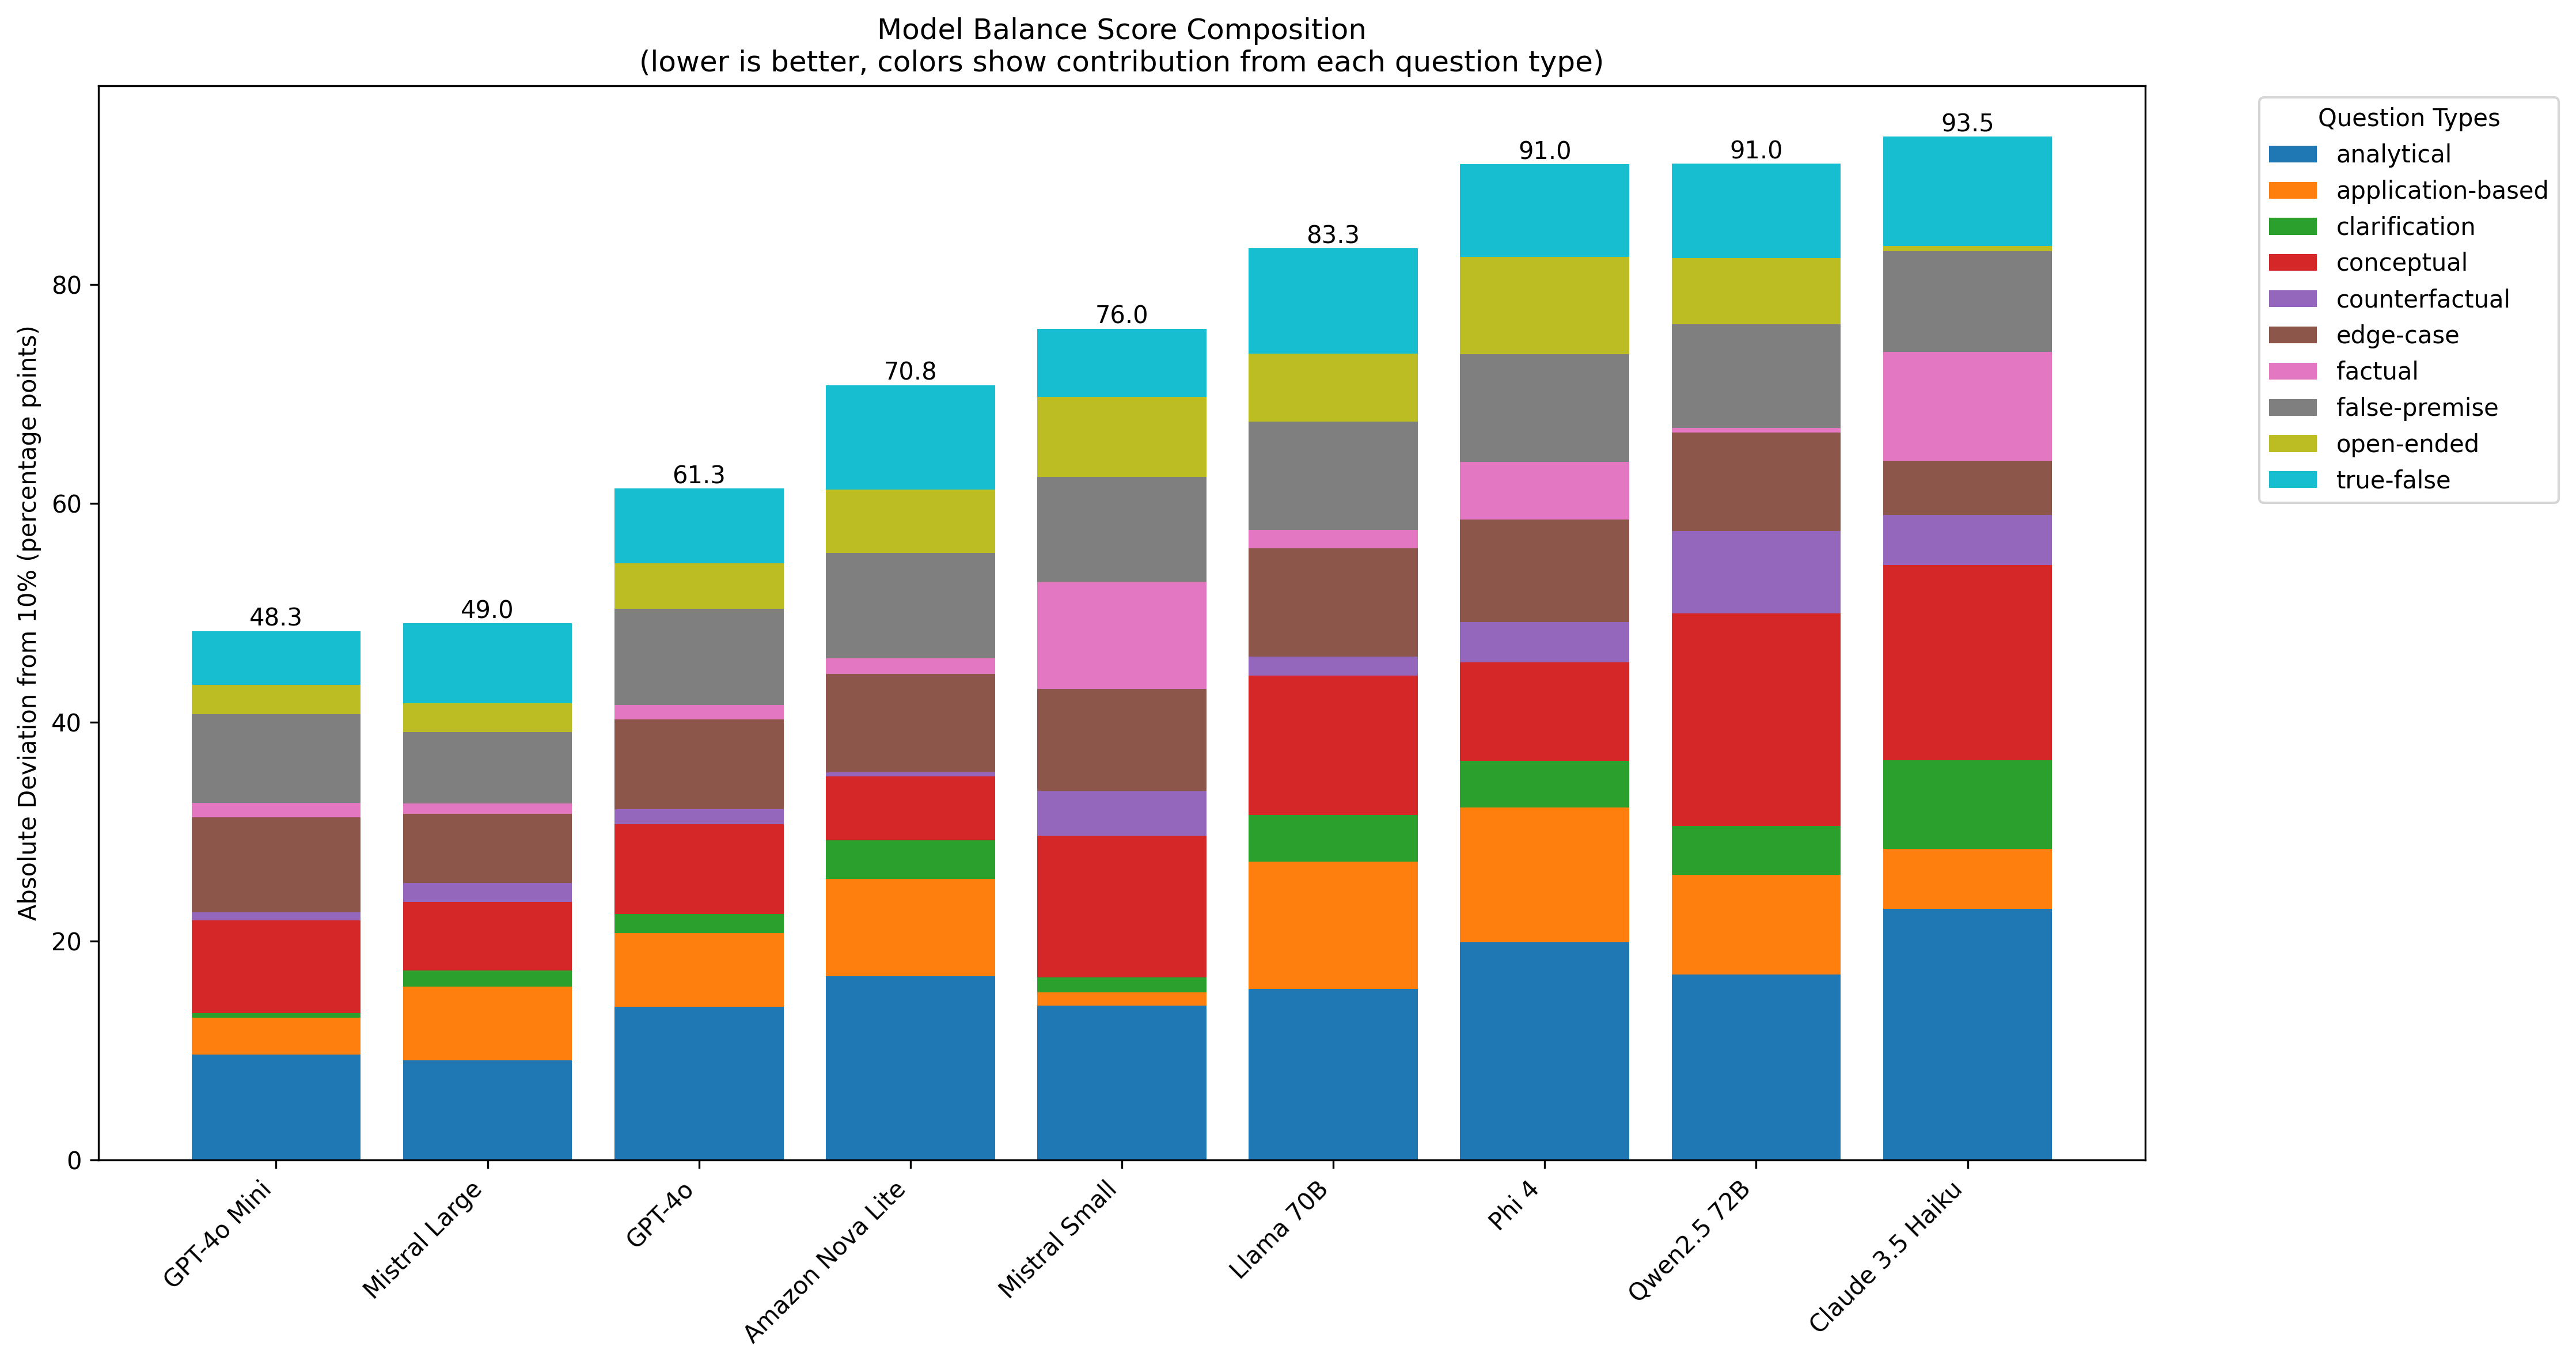

In [21]:
# Calculate deviations and prepare data for stacked bar chart
model_deviations = {}
for model in generating_models:
    model_data = single_hop_question_dataset[single_hop_question_dataset['generating_model'] == model]
    actual_counts = model_data['question_type'].value_counts()
    actual_pct = (actual_counts / len(model_data) * 100)
    
    # Fill in missing categories with 0%
    for qt in question_types:
        if qt not in actual_pct.index:
            actual_pct[qt] = 0
            
    # Calculate absolute deviations from 10%
    deviations = abs(actual_pct - 10)
    model_deviations[model_renaming_dict[model]] = deviations

# Convert to DataFrame for easier plotting
df_deviations = pd.DataFrame(model_deviations).T

# Sort models by total deviation
total_deviations = df_deviations.sum(axis=1)
sorted_models = total_deviations.sort_values().index

# Create stacked bar chart
plt.figure(figsize=(15, 8), dpi=300)

bottom = np.zeros(len(sorted_models))
for question_type in df_deviations.columns:
    values = df_deviations.loc[sorted_models, question_type]
    plt.bar(sorted_models, values, bottom=bottom, label=question_type)
    bottom += values

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.ylabel('Absolute Deviation from 10% (percentage points)')
plt.title('Model Balance Score Composition\n(lower is better, colors show contribution from each question type)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Question Types')

# Add total value labels on top of bars
for i, model in enumerate(sorted_models):
    total = df_deviations.loc[model].sum()
    plt.text(i, total, f'{total:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

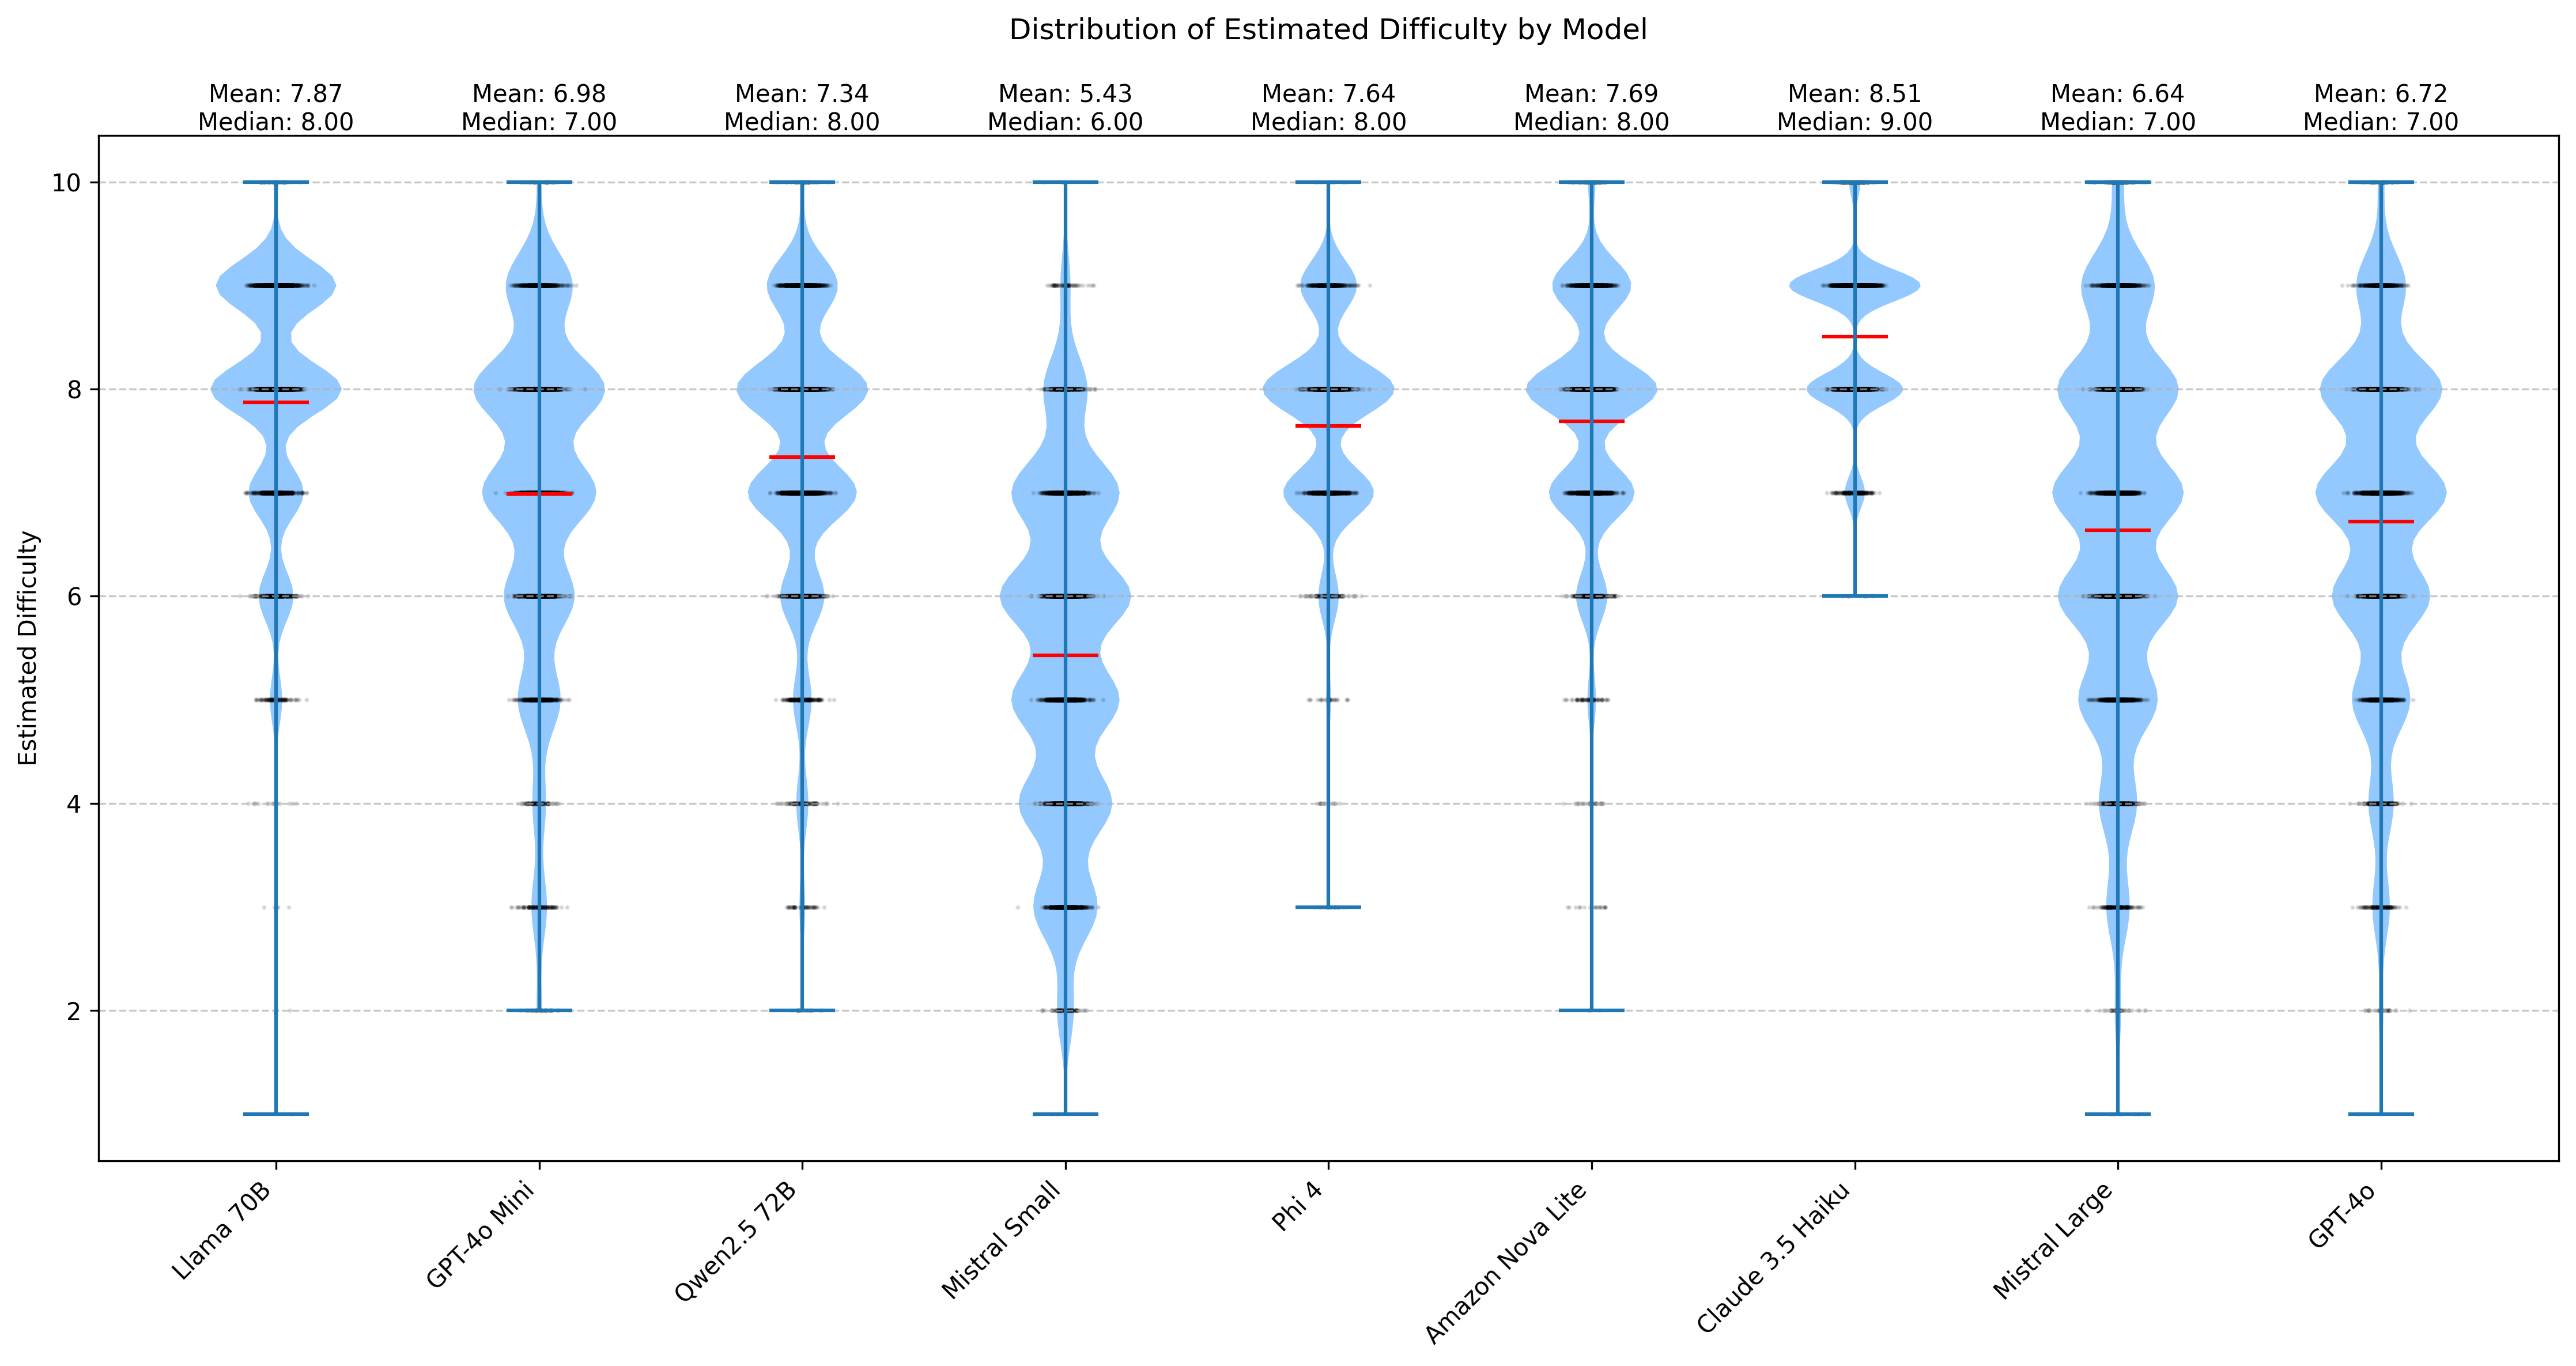


Summary Statistics:

Llama 70B:
count    2898.000000
mean        7.871291
std         1.181930
min         1.000000
25%         7.000000
50%         8.000000
75%         9.000000
max        10.000000
Name: estimated_difficulty, dtype: float64

GPT-4o Mini:
count    3373.000000
mean        6.984583
std         1.594325
min         2.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        10.000000
Name: estimated_difficulty, dtype: float64

Qwen2.5 72B:
count    3573.000000
mean        7.342289
std         1.396121
min         2.000000
25%         7.000000
50%         8.000000
75%         8.000000
max        10.000000
Name: estimated_difficulty, dtype: float64

Mistral Small:
count    3406.000000
mean        5.431885
std         1.629545
min         1.000000
25%         4.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: estimated_difficulty, dtype: float64

Phi 4:
count    1819.000000
mean        7.642111
std         1.069637
min     

In [24]:
# Create figure with higher DPI
plt.figure(figsize=(15, 8), dpi=300)

# Create violin plot with box plot inside
violin_parts = plt.violinplot([
    single_hop_question_dataset[single_hop_question_dataset['generating_model'] == model]['estimated_difficulty']
    for model in generating_models
], showmeans=True)

# Customize violin plot colors
violin_parts['cmeans'].set_color('red')  # Mean marker
for pc in violin_parts['bodies']:
    pc.set_facecolor('#66b3ff')
    pc.set_alpha(0.7)

# Add individual points with jitter for better distribution visibility
for idx, model in enumerate(generating_models):
    difficulties = single_hop_question_dataset[single_hop_question_dataset['generating_model'] == model]['estimated_difficulty']
    # Add jitter to x-position
    x = np.random.normal(idx + 1, 0.04, size=len(difficulties))
    plt.scatter(x, difficulties, alpha=0.1, s=1, color='black')

# Customize the plot
plt.xticks(range(1, len(generating_models) + 1), 
           [model_renaming_dict[model] for model in generating_models],
           rotation=45,
           ha='right')
plt.ylabel('Estimated Difficulty')
plt.title('Distribution of Estimated Difficulty by Model', pad=40)  # Added padding to title

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Calculate and display statistics
for idx, model in enumerate(generating_models):
    difficulties = single_hop_question_dataset[single_hop_question_dataset['generating_model'] == model]['estimated_difficulty']
    mean = difficulties.mean()
    median = difficulties.median()
    plt.text(idx + 1, plt.ylim()[1], 
             f'Mean: {mean:.2f}\nMedian: {median:.2f}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
for model in generating_models:
    difficulties = single_hop_question_dataset[single_hop_question_dataset['generating_model'] == model]['estimated_difficulty']
    print(f"\n{model_renaming_dict[model]}:")
    print(difficulties.describe())

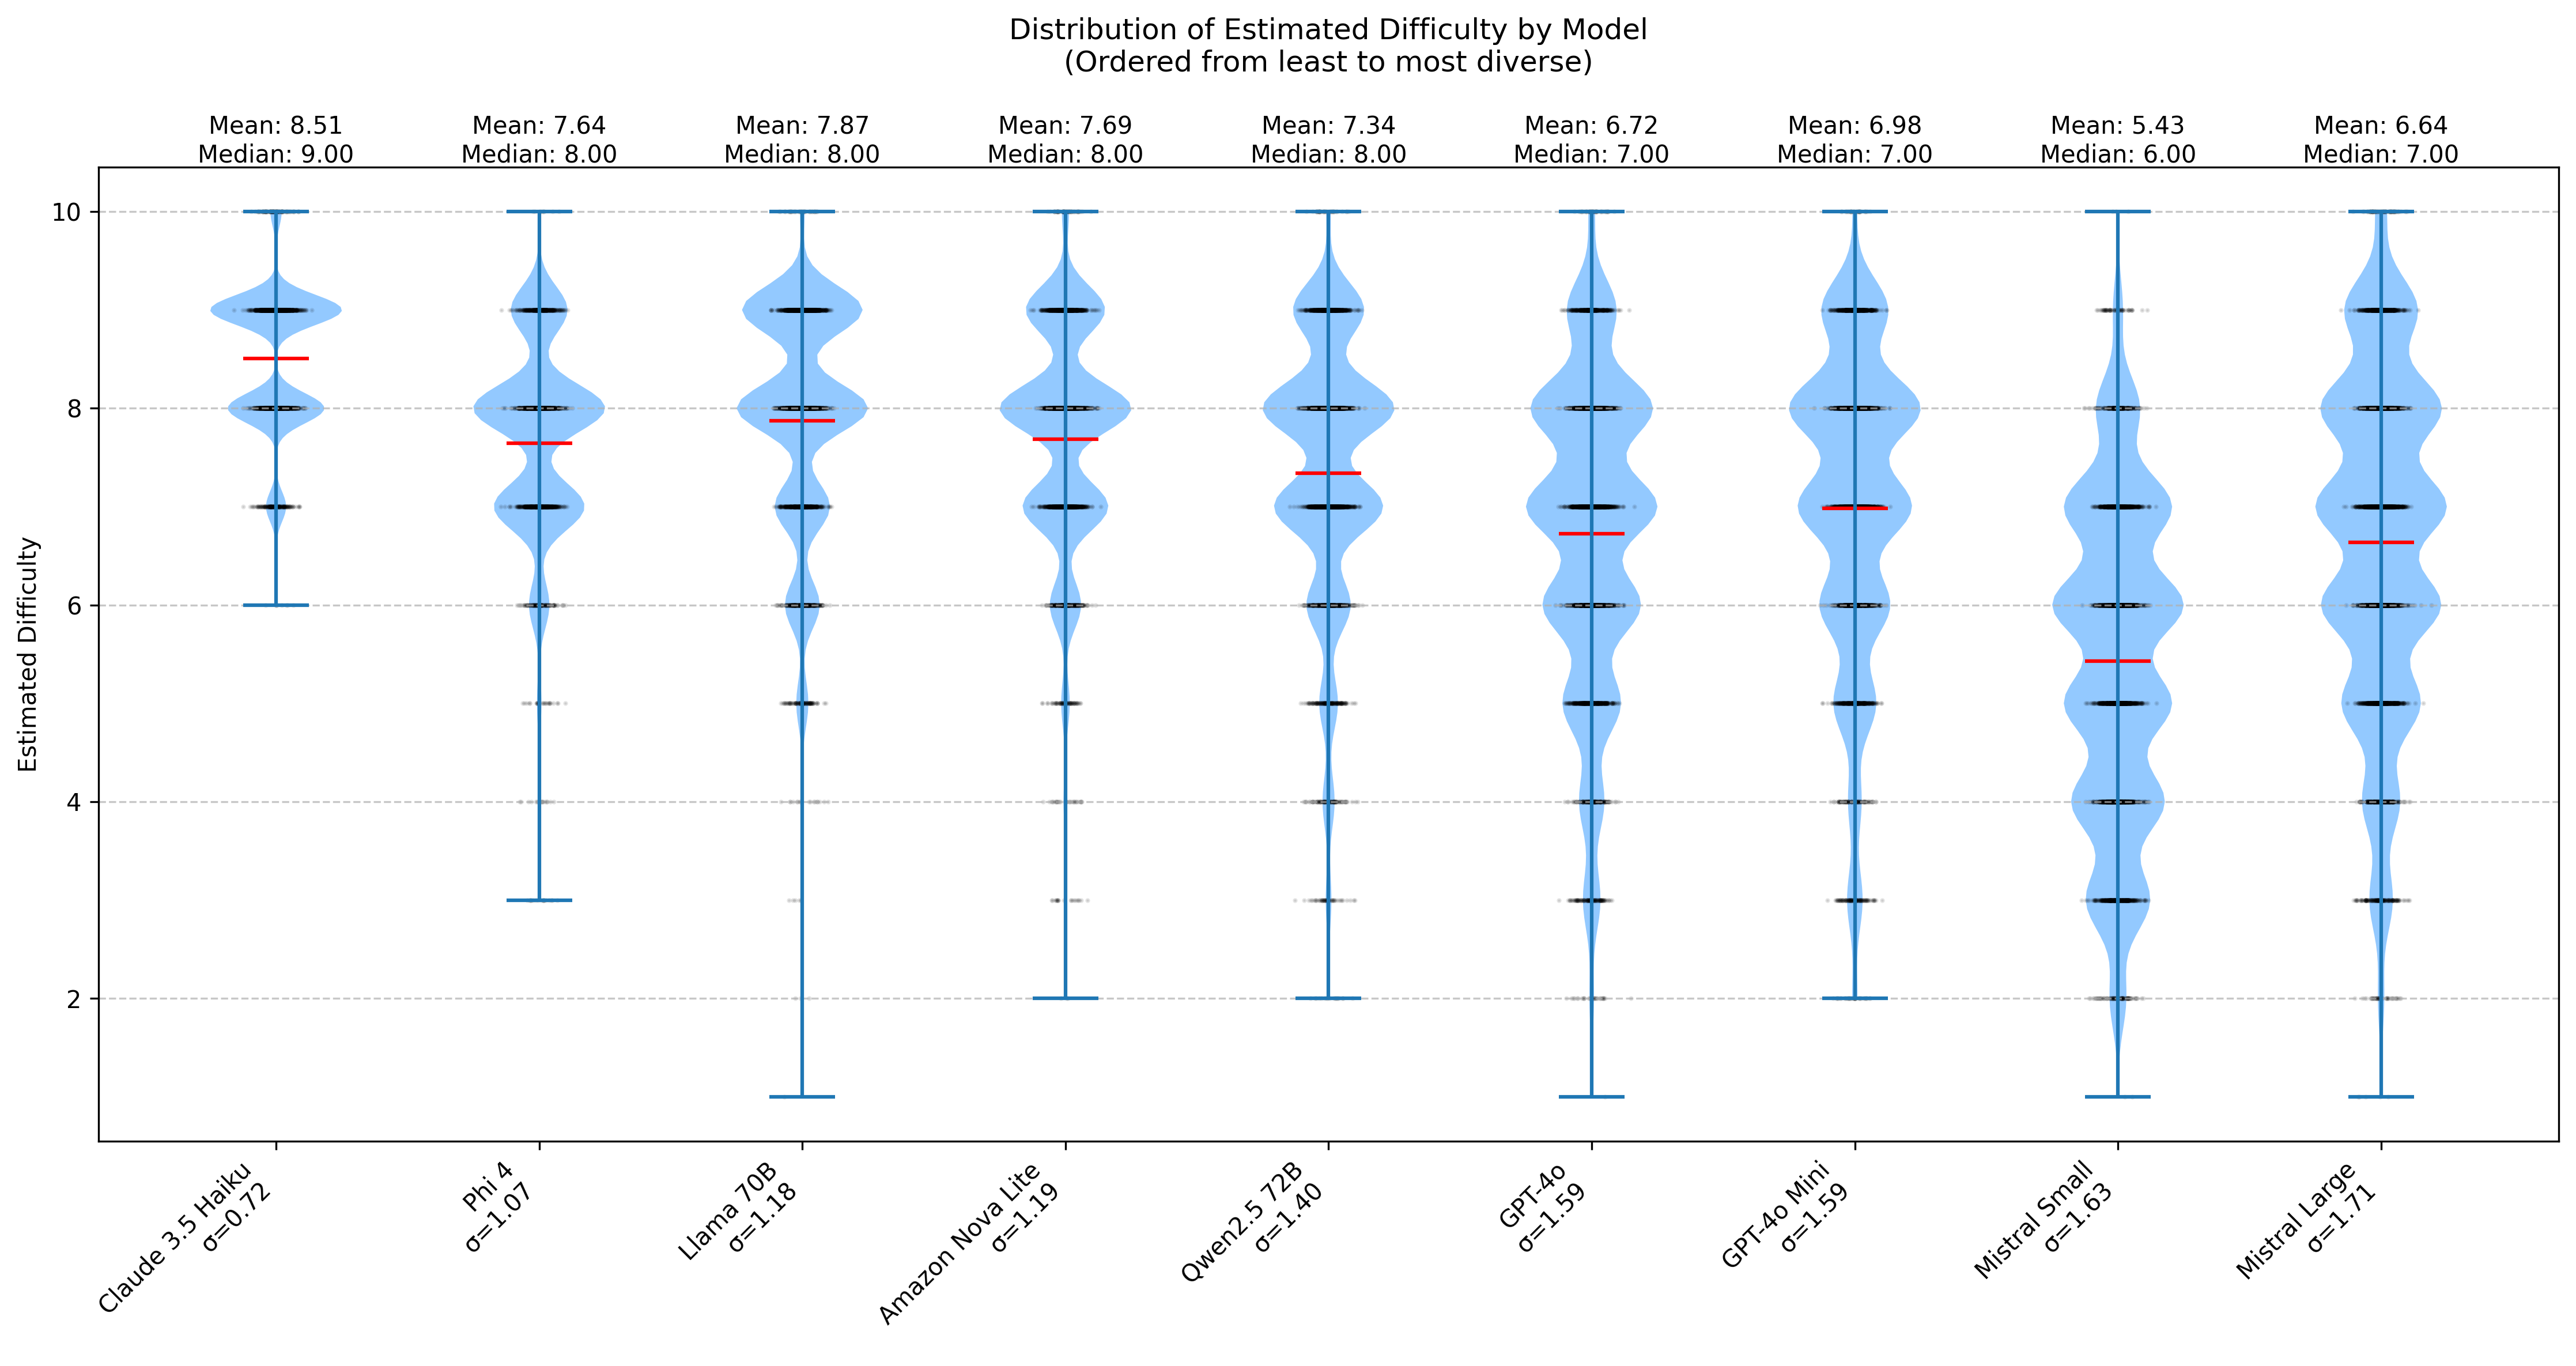


Summary Statistics (ordered by diversity):

Claude 3.5 Haiku (σ=0.72):
count    2294.000000
mean        8.507847
std         0.715341
min         6.000000
25%         8.000000
50%         9.000000
75%         9.000000
max        10.000000
Name: estimated_difficulty, dtype: float64

Phi 4 (σ=1.07):
count    1819.000000
mean        7.642111
std         1.069637
min         3.000000
25%         7.000000
50%         8.000000
75%         8.000000
max        10.000000
Name: estimated_difficulty, dtype: float64

Llama 70B (σ=1.18):
count    2898.000000
mean        7.871291
std         1.181930
min         1.000000
25%         7.000000
50%         8.000000
75%         9.000000
max        10.000000
Name: estimated_difficulty, dtype: float64

Amazon Nova Lite (σ=1.19):
count    2788.000000
mean        7.687231
std         1.188883
min         2.000000
25%         7.000000
50%         8.000000
75%         8.000000
max        10.000000
Name: estimated_difficulty, dtype: float64

Qwen2.5 72B (σ=1.

In [26]:
# Calculate standard deviations for each model
model_stds = {}
for model in generating_models:
    difficulties = single_hop_question_dataset[single_hop_question_dataset['generating_model'] == model]['estimated_difficulty']
    model_stds[model] = difficulties.std()

# Sort models by standard deviation
sorted_models = sorted(generating_models, key=lambda x: model_stds[x])

# Create figure with higher DPI
plt.figure(figsize=(15, 8), dpi=300)

# Create violin plot with sorted models
violin_parts = plt.violinplot([
    single_hop_question_dataset[single_hop_question_dataset['generating_model'] == model]['estimated_difficulty']
    for model in sorted_models
], showmeans=True)

# Customize violin plot colors
violin_parts['cmeans'].set_color('red')
for pc in violin_parts['bodies']:
    pc.set_facecolor('#66b3ff')
    pc.set_alpha(0.7)

# Add individual points with jitter
for idx, model in enumerate(sorted_models):
    difficulties = single_hop_question_dataset[single_hop_question_dataset['generating_model'] == model]['estimated_difficulty']
    x = np.random.normal(idx + 1, 0.04, size=len(difficulties))
    plt.scatter(x, difficulties, alpha=0.1, s=1, color='black')

# Customize the plot
plt.xticks(range(1, len(sorted_models) + 1), 
           [f"{model_renaming_dict[model]}\nσ={model_stds[model]:.2f}" for model in sorted_models],
           rotation=45,
           ha='right')
plt.ylabel('Estimated Difficulty')
plt.title('Distribution of Estimated Difficulty by Model\n(Ordered from least to most diverse)', pad=40)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Calculate and display statistics
for idx, model in enumerate(sorted_models):
    difficulties = single_hop_question_dataset[single_hop_question_dataset['generating_model'] == model]['estimated_difficulty']
    mean = difficulties.mean()
    median = difficulties.median()
    plt.text(idx + 1, plt.ylim()[1], 
             f'Mean: {mean:.2f}\nMedian: {median:.2f}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics (ordered by diversity):")
for model in sorted_models:
    difficulties = single_hop_question_dataset[single_hop_question_dataset['generating_model'] == model]['estimated_difficulty']
    print(f"\n{model_renaming_dict[model]} (σ={model_stds[model]:.2f}):")
    print(difficulties.describe())

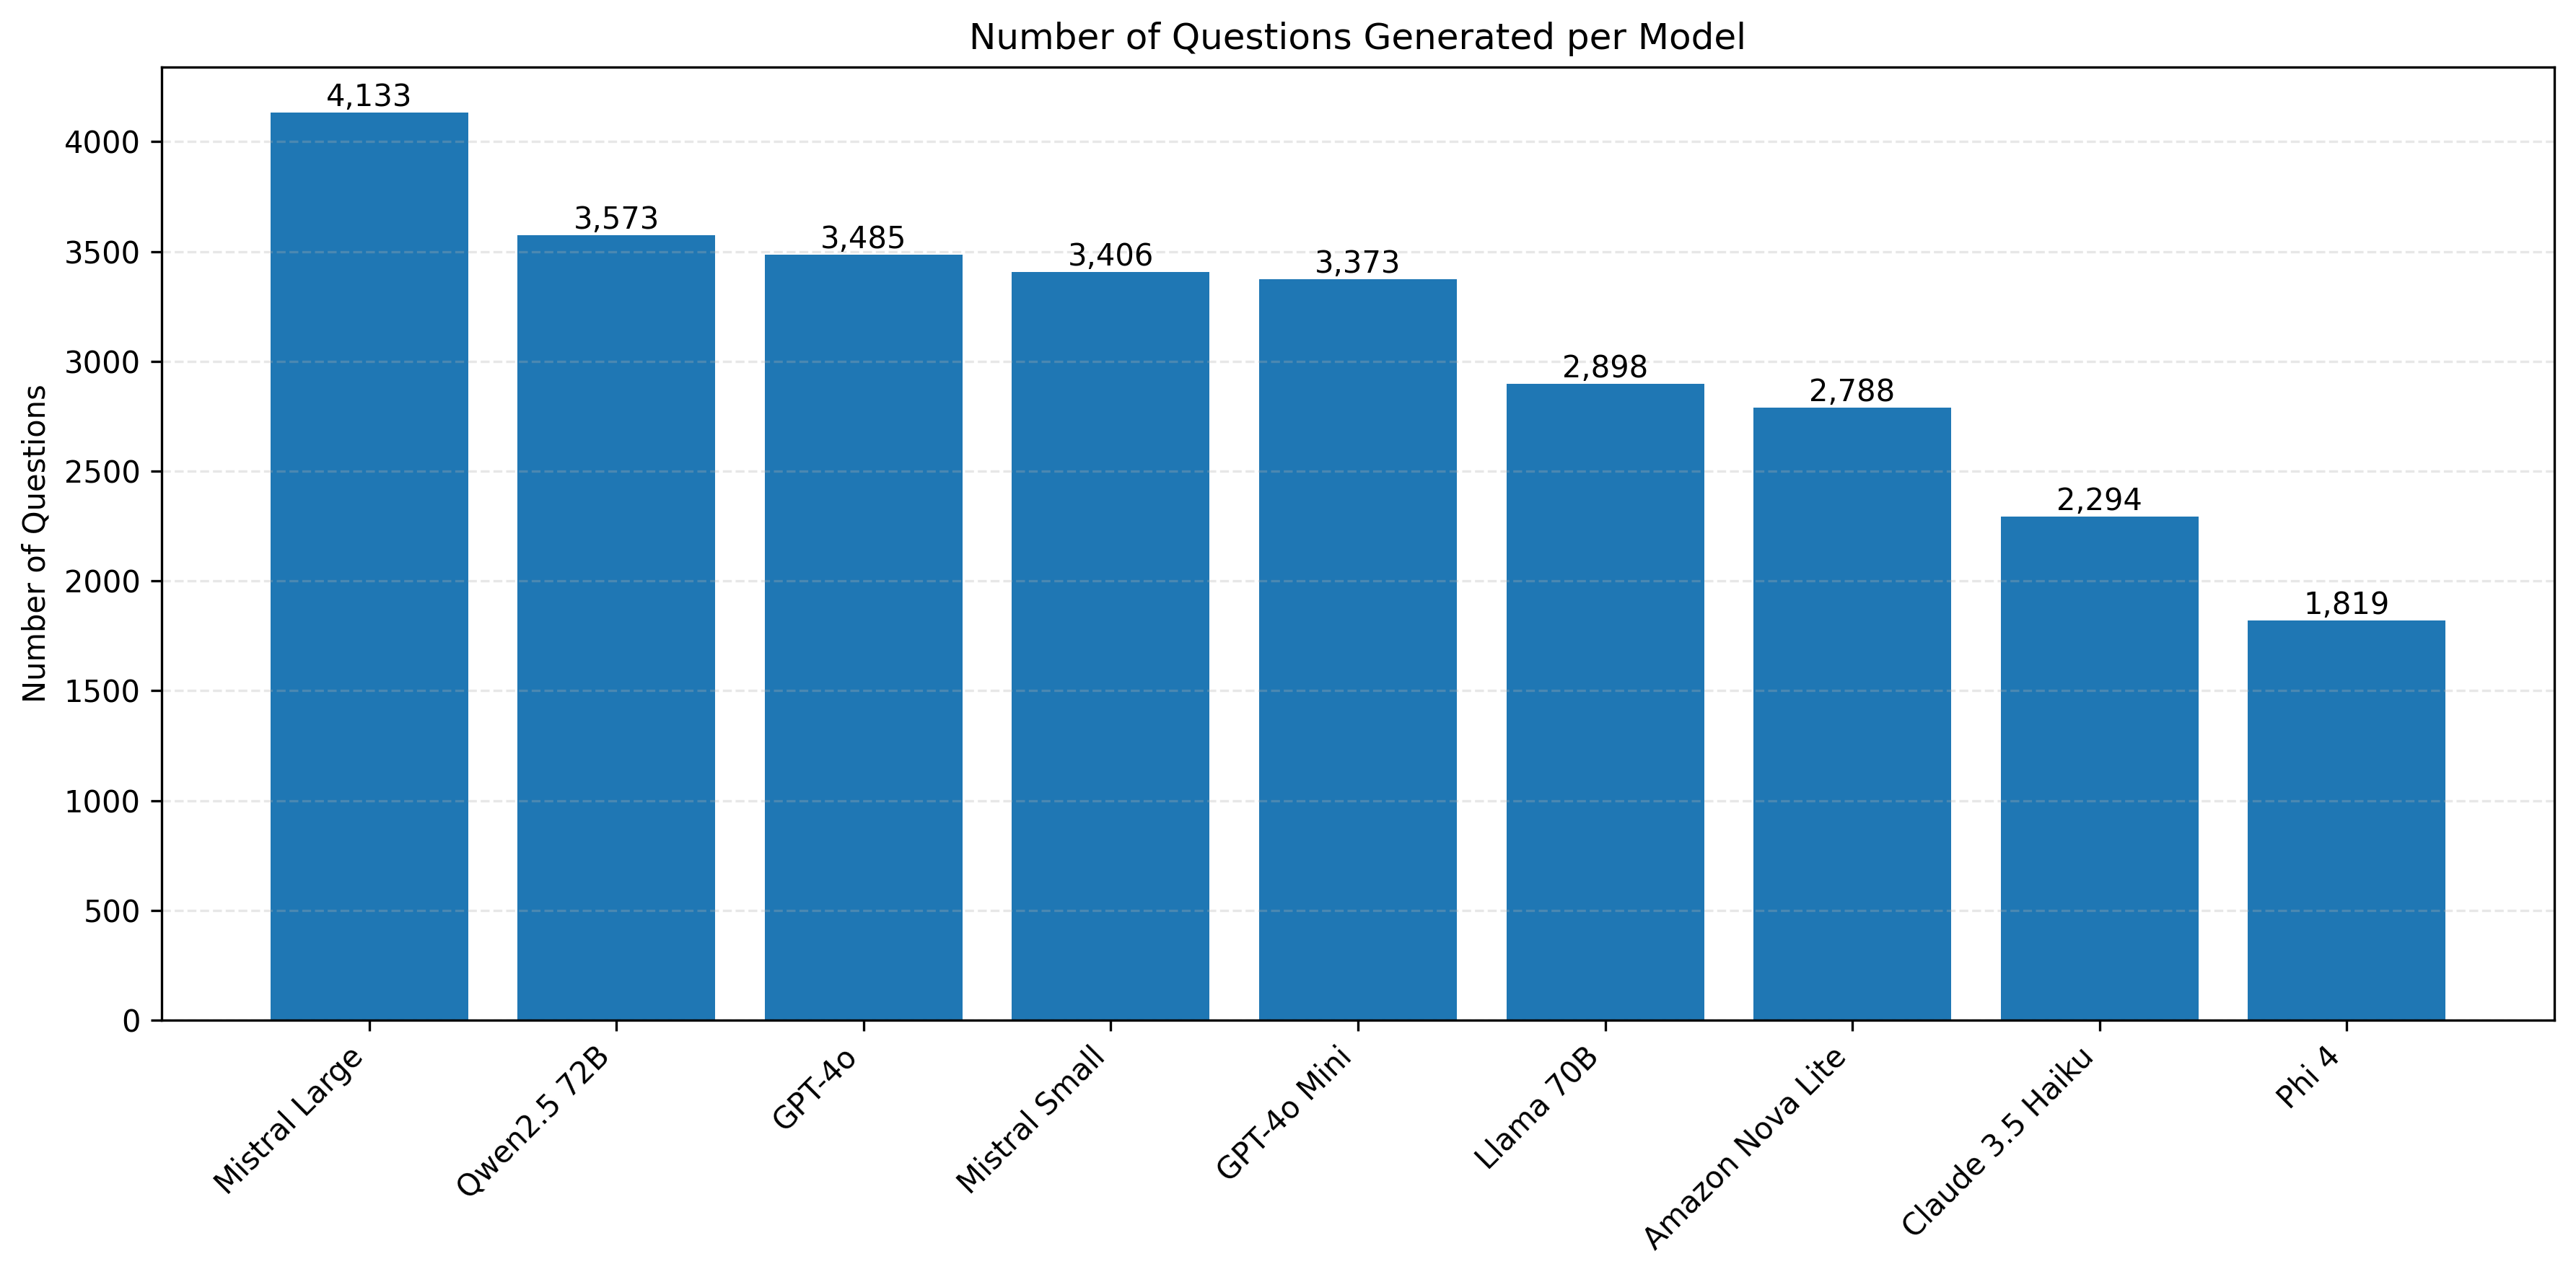

In [27]:
# Count questions per model
question_counts = single_hop_question_dataset['generating_model'].value_counts()

# Create bar chart
plt.figure(figsize=(12, 6), dpi=300)

# Create bars with friendly model names
bars = plt.bar(
    [model_renaming_dict[model] for model in question_counts.index],
    question_counts.values
)

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Questions')
plt.title('Number of Questions Generated per Model')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',  # Format with commas for thousands
             ha='center', va='bottom')

plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
print(single_hop_question_dataset.columns)

Index(['question_id', 'document_id', 'document_name', 'document_category',
       'document_summary', 'chunk_location_id', 'chunk', 'test_audience',
       'full_generation_response', 'document_analysis', 'question_type',
       'thought_process', 'question', 'answer', 'estimated_difficulty',
       'citations', 'generating_model'],
      dtype='object')


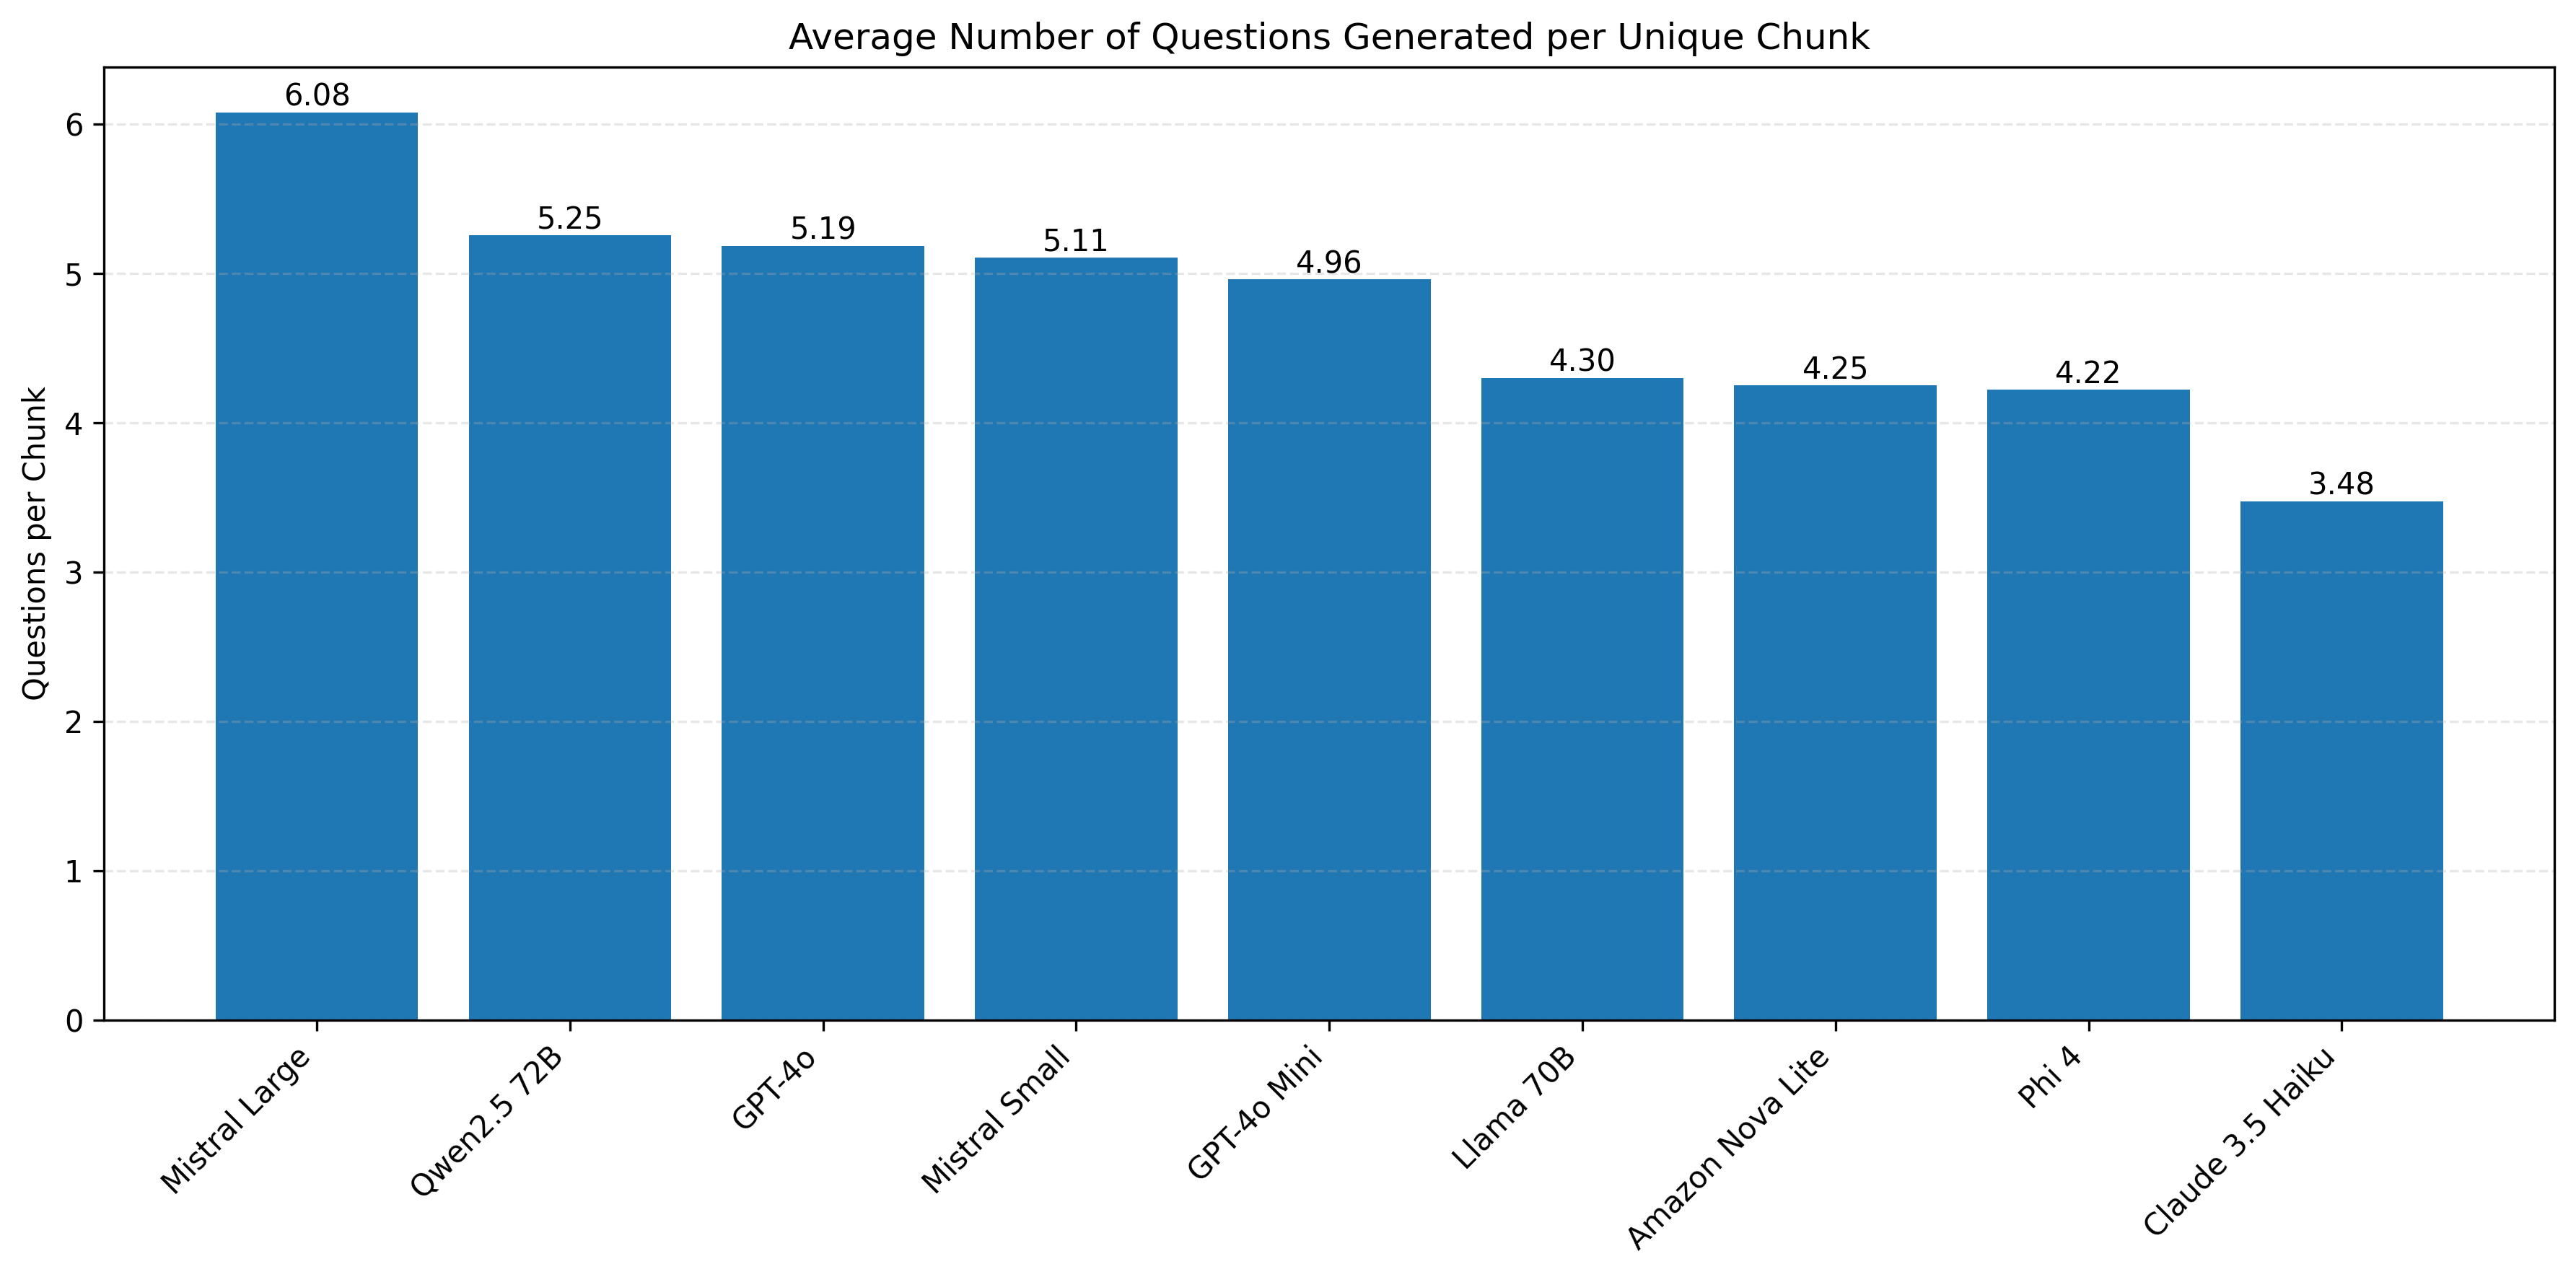


Detailed Statistics (sorted by questions per chunk):

Mistral Large:
Total Questions: 4,133
Unique Chunks: 680
Questions per Chunk: 6.08

Qwen2.5 72B:
Total Questions: 3,573
Unique Chunks: 680
Questions per Chunk: 5.25

GPT-4o:
Total Questions: 3,485
Unique Chunks: 672
Questions per Chunk: 5.19

Mistral Small:
Total Questions: 3,406
Unique Chunks: 667
Questions per Chunk: 5.11

GPT-4o Mini:
Total Questions: 3,373
Unique Chunks: 680
Questions per Chunk: 4.96

Llama 70B:
Total Questions: 2,898
Unique Chunks: 674
Questions per Chunk: 4.30

Amazon Nova Lite:
Total Questions: 2,788
Unique Chunks: 656
Questions per Chunk: 4.25

Phi 4:
Total Questions: 1,819
Unique Chunks: 431
Questions per Chunk: 4.22

Claude 3.5 Haiku:
Total Questions: 2,294
Unique Chunks: 660
Questions per Chunk: 3.48


In [30]:
# Count questions and unique chunks per model
questions_per_model = single_hop_question_dataset['generating_model'].value_counts()
chunks_per_model = single_hop_question_dataset.groupby('generating_model')['chunk'].nunique()

# Calculate ratio and sort
questions_per_chunk = questions_per_model / chunks_per_model
questions_per_chunk = questions_per_chunk.sort_values(ascending=False)  # Sort from highest to lowest

# Create bar chart
plt.figure(figsize=(12, 6), dpi=300)

# Create bars with friendly model names
bars = plt.bar(
    [model_renaming_dict[model] for model in questions_per_chunk.index],
    questions_per_chunk.values
)

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.ylabel('Questions per Chunk')
plt.title('Average Number of Questions Generated per Unique Chunk')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',  # Show with 2 decimal places
             ha='center', va='bottom')

plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Statistics (sorted by questions per chunk):")
for model in questions_per_chunk.index:
    print(f"\n{model_renaming_dict[model]}:")
    print(f"Total Questions: {questions_per_model[model]:,}")
    print(f"Unique Chunks: {chunks_per_model[model]:,}")
    print(f"Questions per Chunk: {questions_per_chunk[model]:.2f}")